In [126]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

# отключим вывод варнингов
warnings.filterwarnings('ignore')

In [2]:
stud_math = pd.read_csv('stud_math.csv')

Просмотрим исходные данные датасета. Посмотрим количество записей, количество признаков (и что это за признаки), оценим количество ненулевых значений по колонкам.

In [3]:
stud_math.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [4]:
print(list(stud_math))

['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'studytime, granular', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health', 'absences', 'score']


Для удобства дальнейшей работы переведем все названия колонок к единому виду (все с маленькой буквы) и переименуем колонки Medu, Fedu, Mjob, Fjob в более понятные для последующего анализа и интерпретации mother_edu, father_edu, mother_job, father_job

In [5]:
stud_math.columns = ['school', 'sex', 'age', 'address', 'famsize', 'pstatus', 'mother_edu', 'father_edu',
                     'mother_job', 'father_job', 'reason', 'guardian', 'traveltime', 'studytime',
                     'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
                     'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
                     'freetime', 'goout', 'health', 'absences', 'score']

Разберемся с признаками, которые содержат числовые значения.

В первую очередь рассмотрим признак score (то есть собственно итоговая оценка, полученная учеником), так как именно все последующие признаки мы будем рассматривать с точки зрения влияния их на score.

Посмотрим какие уникальные значения присутствуют в этой колонке

In [7]:
stud_math.score.unique()

array([ 30.,  50.,  75.,  55.,  95.,  45.,  60.,  70.,  80.,  25.,  40.,
        85.,  90.,  65., 100.,  35.,   0.,  nan,  20.])

Данных у нас много, мы смело можем заменить NaN на медианное значение. Но для начала посмотрим распределение значений признака и найдем медианное значение. 

55.0

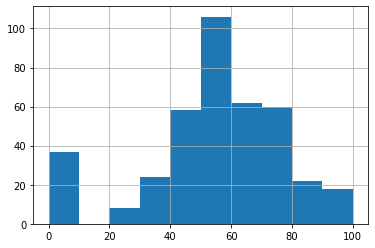

In [12]:
stud_math.score.hist()
stud_math.score.median()

Заменим NaN медианным значением. 

In [10]:
stud_math.score.fillna(55., inplace=True)

Судя по гистограмме у нас присутствуют выбросы (и в большом количестве). Проверим.

In [13]:
median = stud_math.score.median()
IQR = stud_math.score.quantile(0.75) - stud_math.score.quantile(0.25)
perc25 = stud_math.score.quantile(0.25)
perc75 = stud_math.score.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


Формула показывает, что выбросов нет и нулевые оценки входят в допустимые границы. Оставим пока этот признак без вмешательства. Хотя, позже я бы к нему вернулся, так как 0.0 означает, что ученик скорее всего вовсе не сдавал контрольную и стоит ли рассматривать его данные - большой вопрос. 

Займемся теперь прочими признаками с численными значениями. 
Это колонки 'age','mother_edu','father_edu', 'traveltime','studytime', 'failures', 'studytime, granular', 'famrel', 'freetime', 'goout', 'health', 'absences'.

Посмотрим колонку 'age'

In [14]:
stud_math.age.unique()

array([18, 17, 15, 16, 19, 22, 20, 21])

Пропущенных значений нет, посмотрим распределение признака и сразу проверим нет ли выбросов.

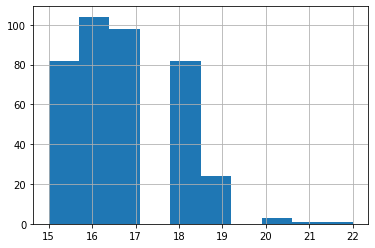

In [15]:
stud_math.age.hist()

In [16]:
median = stud_math.age.median()
IQR = stud_math.age.quantile(0.75) - stud_math.age.quantile(0.25)
perc25 = stud_math.age.quantile(0.25)
perc75 = stud_math.age.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


Видим, что есть значения, которые выходят за рамки выбросов (возраст 22 года). Избавимся от выброса

In [17]:
stud_math = stud_math.loc[stud_math.age.between(
    perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

Просмотрим колонку 'mother_edu' и проверим его на наличие пустых значений.

In [18]:
stud_math.mother_edu.unique()

array([ 4.,  1.,  3.,  2., nan,  0.])

Посмотрим на распределение числового признака mother_edu

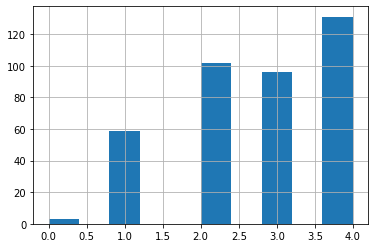

In [19]:
stud_math.mother_edu.hist()

Посмотрим строки с пропущенными значениями по колонке mother_edu. Просто чтобы оценить насколько ценная там информация по другим колонкам.

In [20]:
stud_math[stud_math.mother_edu.isnull()]

,school,sex,age,address,famsize,pstatus,mother_edu,father_edu,mother_job,father_job,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
92,GP,F,16,NaN,LE3,T,NaN,1.0,other,other,...,-6.0,yes,no,no,3.0,3.0,NaN,2.0,4.0,30.0
193,GP,M,16,R,GT3,NaN,NaN,3.0,services,services,...,-3.0,yes,yes,no,4.0,3.0,2.0,5.0,8.0,50.0
239,GP,M,18,U,GT3,NaN,NaN,2.0,other,services,...,-6.0,no,NaN,NaN,5.0,5.0,4.0,2.0,0.0,0.0


Видим, что в строках, с пропусками по mother_edu много пропусков и по другим признакам. Думаю, что эти строки нужно удалить, чтобы не плодить "отсебятину", заполняя множество признаков выдуманными значениями по одному и тому же ученику. 

In [21]:
stud_math.dropna(subset=['mother_edu'], inplace=True)

Проверять колонку 'mother_edu' (как и колонку 'father_edu') на выбросы я не буду, так как численная эта колонка только формально. Число в ней - это конкретная информация (0 - отсутствие какого бы то ни было образования у матери или отца). Терять ее нельзя.

Проверим колонку 'father_edu' на наличие пустых значений

In [22]:
stud_math.father_edu.unique()

array([ 4.,  1.,  2.,  3., 40., nan,  0.])

Видим, что есть пустые значения и странное значение "40". Значение 40 скорее всего опечатка и должно было быть 4.Исправим 40 на 4

In [23]:
stud_math.father_edu = stud_math.father_edu.apply(
    lambda x: 4. if x == 40. else x)

Посмотрим на количество пустых значений в колонке father_edu.

In [24]:
stud_math.father_edu.isna().sum()

24

Пустых значений многовато, для того, чтобы просто от них избавиться... Посмотрим контекст. Цифра - это уровень образования отца. от "0" - нет образования, до 4 - высшее. Медианное значение (3, то есть 11 классов) в данном случае использовать - на мой взглял - неправильно. Будем считать, что пропущенные значения - это отсутствие образования вовсе, то есть мы можем заполнить в этой колнке NaN нулем.

In [25]:
stud_math.father_edu.fillna(0, inplace=True)

Посмотрим на распределние признака

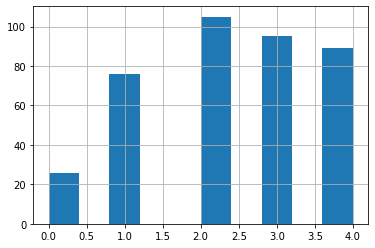

In [26]:
stud_math.father_edu.hist()

Займемся столбцом "traveltime". Посмотрим есть ли в этой колонке пустые значения.

In [27]:
stud_math.traveltime.unique()

array([ 2.,  1.,  3., nan,  4.])

Пустые значения есть. Оценим их количество.

In [28]:
stud_math.traveltime.isna().sum()

28

Пустых значений много. Удалять их было бы чувствительной потерей для датасета. Посмотрим, чем можно заменить пустые значения. Для начала оценим распределение признака и вычислим меидану.

1.0

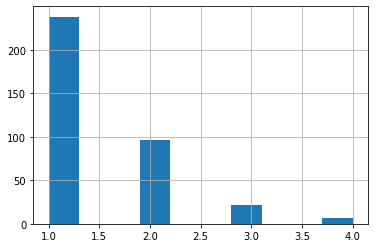

In [29]:
stud_math.traveltime.hist()
stud_math.traveltime.median()

Так вышло, что медианное значение признака совпадает с наиболее часто встречающимся значением. Все за то, чтобы заменить пропущенные значения 1 (то есть время в пути от дома до школы менее 15 минут)

In [30]:
stud_math.traveltime.fillna(1., inplace=True)

Займемся столбцом " studytime". Посмотрим есть ли в этой колонке пустые значения.

In [31]:
stud_math.studytime.unique()

array([ 2.,  3.,  1., nan,  4.])

Оценим количество NaN

In [32]:
stud_math.studytime.isna().sum()

7

 Посмотрим, чем можно заменить пустые значения. Для начала оценим распределение признака и вычислим меидану.

2.0

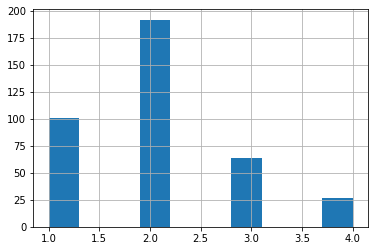

In [33]:
stud_math.studytime.hist()
stud_math.studytime.median()

Думаю, что можно заменить отсутствующие значения медианным (и самым распространенным) значением 2 (это выглядит разумно, так означает 2-2,5 часа занятий в неделю помимо школы)

In [34]:
stud_math.studytime.fillna(2., inplace=True)

Посмотрим данные колонки failures. Посмотрим есть ли пустые значения и если есть, то сколько их.

In [36]:
stud_math.failures.isna().sum()

22

Пустых данных довольно много. Подумаем чем бы их можно было заменить. Для этого для начала посмотрим на распределние признака и вычислим медиану

0.0

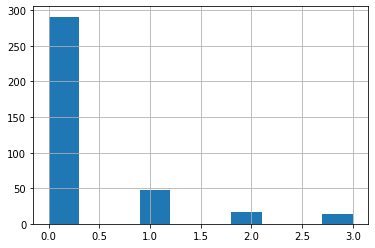

In [37]:
stud_math.failures.hist()
stud_math.failures.median()

Видим, что опять все за то, чтобы заменить пропушенные значения медианным и самым распротраненным(то есть нулем). Здравй смысл за то же. 0 - означает, что количество внеучебных неудач (что бы это ни значило) или 0 или больше 3.

In [38]:
stud_math.failures.fillna(0., inplace=True)

Посмотрим на колонку famreal: какие присутствуют значения, есть ли пустые и "странные" значения.

In [39]:
stud_math.famrel.unique()

array([ 4.,  5.,  3., nan, -1.,  2.,  1.])

Среди значений присутствует -1. Так как значения в колонке от 1 (очень плохо), до 5 (очень хорошо), то скорее всего -1 - это эмоционально окрашенное подчеркивание 1 (очень плохо). Заменим

In [40]:
stud_math.famrel = stud_math.famrel.apply(lambda x: 1. if x == -1. else x)

Теперь оценим количество пустых значений.

In [41]:
stud_math.famrel.isna().sum()

27

Пустых значений опять слишком много для просто выбрасывания этих строк. Подумаем чем заменить. Для этого для начала посмотрим на распределение признака и вычислим медиану.

4.0

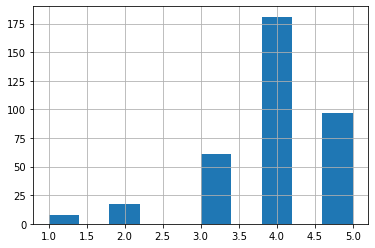

In [42]:
stud_math.famrel.hist()
stud_math.famrel.median()

Все за то, чтобы заменить пустые значения на 4 (отношения в семье хорошие), хотя я бы поставил 3 (нормальные). Заменим пустые значения на 4

In [43]:
stud_math.famrel.fillna(4., inplace=True)

Очередь признака freetime. Посмотрим какие есть значения в этой колонке. Нет ли пустых или странных.

In [44]:
stud_math.freetime.unique()

array([ 3.,  2.,  4.,  1.,  5., nan])

Оценим количество пустых значений.

In [45]:
stud_math.freetime.isna().sum()

11

Чтобы понять чем можно заменить пустые значения, построим гистограмму и вычислим медиану.

3.0

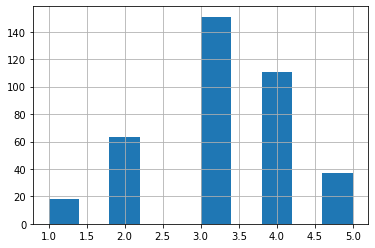

In [47]:
stud_math.freetime.hist()
stud_math.freetime.median()

И здравый смысл и показатели медианы и распределния говорят о том, что нужно заменять пропушенные значения на 3 (то есть у ученика среднее количество свободного времени)

In [48]:
stud_math.freetime.fillna(3., inplace=True)

Займемся колонкой health

In [50]:
stud_math.health.unique()

array([ 3.,  5.,  1.,  2.,  4., nan])

Оценим количество пустых значений

In [52]:
stud_math.health.isna().sum()

15

Для того чтобы понять на что заменить пустые значения, посмотрим на гистограмму и вычислим медианное значение.

4.0

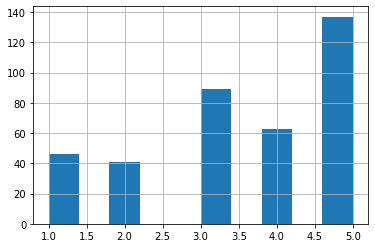

In [54]:
stud_math.health.hist()
stud_math.health.median()

И здравый смысл и показатели медианы и распределния говорят о том, что нужно заменять пропушенные значения на 4 (то есть ученик отвечал на вопрос о здоровье "хорошее")

In [55]:
stud_math.health.fillna(4., inplace=True)

Посмотрим на колонку absences. Посмотрим на то какие в ней есть уникальные значения и есть ли пустые

In [56]:
stud_math.absences.unique()

array([  6.,   4.,  10.,   2.,   0.,  16.,  nan,  14.,   7.,   8.,  25.,
        12.,  54.,  18.,  26.,  20.,  56.,  24.,  28.,   5.,  13.,  15.,
        22.,   3., 385.,  21.,   1.,  75.,  30.,  19.,   9.,  11.,  38.,
        40.,  23.,  17., 212.])

Пустые значения есть. Посмотрим чем им можно заменить.

4.0

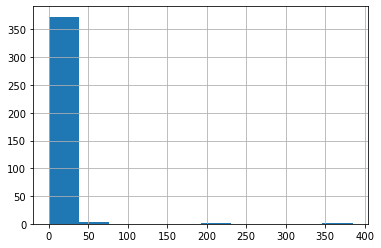

In [58]:
stud_math.absences.hist()
stud_math.absences.median()

Заменим пропущенные значения медианой (4)

In [59]:
stud_math.absences.fillna(4., inplace=True)

Судя по гистограмме, у нас есть выбросы в данной колонке. Проверим.

In [60]:
median = stud_math.absences.median()
IQR = stud_math.absences.quantile(0.75) - stud_math.absences.quantile(0.25)
perc25 = stud_math.absences.quantile(0.25)
perc75 = stud_math.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


Посмотрим много ли значений мы потеряем, удалив выбросы...

In [61]:
stud_math.loc[stud_math.absences.between(
    perc25 - 1.5*IQR, perc75 + 1.5*IQR)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               374 non-null    object 
 1   sex                  374 non-null    object 
 2   age                  374 non-null    int64  
 3   address              358 non-null    object 
 4   famsize              349 non-null    object 
 5   pstatus              336 non-null    object 
 6   mother_edu           374 non-null    float64
 7   father_edu           374 non-null    float64
 8   mother_job           357 non-null    object 
 9   father_job           339 non-null    object 
 10  reason               357 non-null    object 
 11  guardian             344 non-null    object 
 12  traveltime           374 non-null    float64
 13  studytime            374 non-null    float64
 14  failures             374 non-null    float64
 15  schoolsup            365 non-null    obj

Судя по всему удалив все выбросы мы потеряем 10% датасета. Я не буду этого делать, удалив только самые откровенные выбросы (те, где значение зашкаливает за 200 (мы помним, вто в колонке присутствуют данные о пропусках занятий и 200 и 300 пропусков - это уже откровенный перебор)

In [62]:
stud_math = stud_math.loc[stud_math.absences.between(0, 200)]

Рассмторим колнку studytime, granular. Посмотрим наличие и количество пустых значений

In [64]:
stud_math['studytime, granular'].unique()

array([ -6.,  -9.,  -3.,  nan, -12.])

In [65]:
stud_math['studytime, granular'].isna().sum()

7

Подумаем чем можно их заменить. Посмотрим гистограмму и вычислим медиану

-6.0

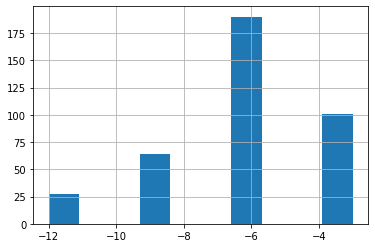

In [66]:
stud_math['studytime, granular'].hist()
stud_math['studytime, granular'].median()

Судя по всему, можно смело заменить пропущенные значения медианой -6.0

In [67]:
stud_math['studytime, granular'].fillna(-6., inplace=True)

Оценим визуально корреляцию численных признаков

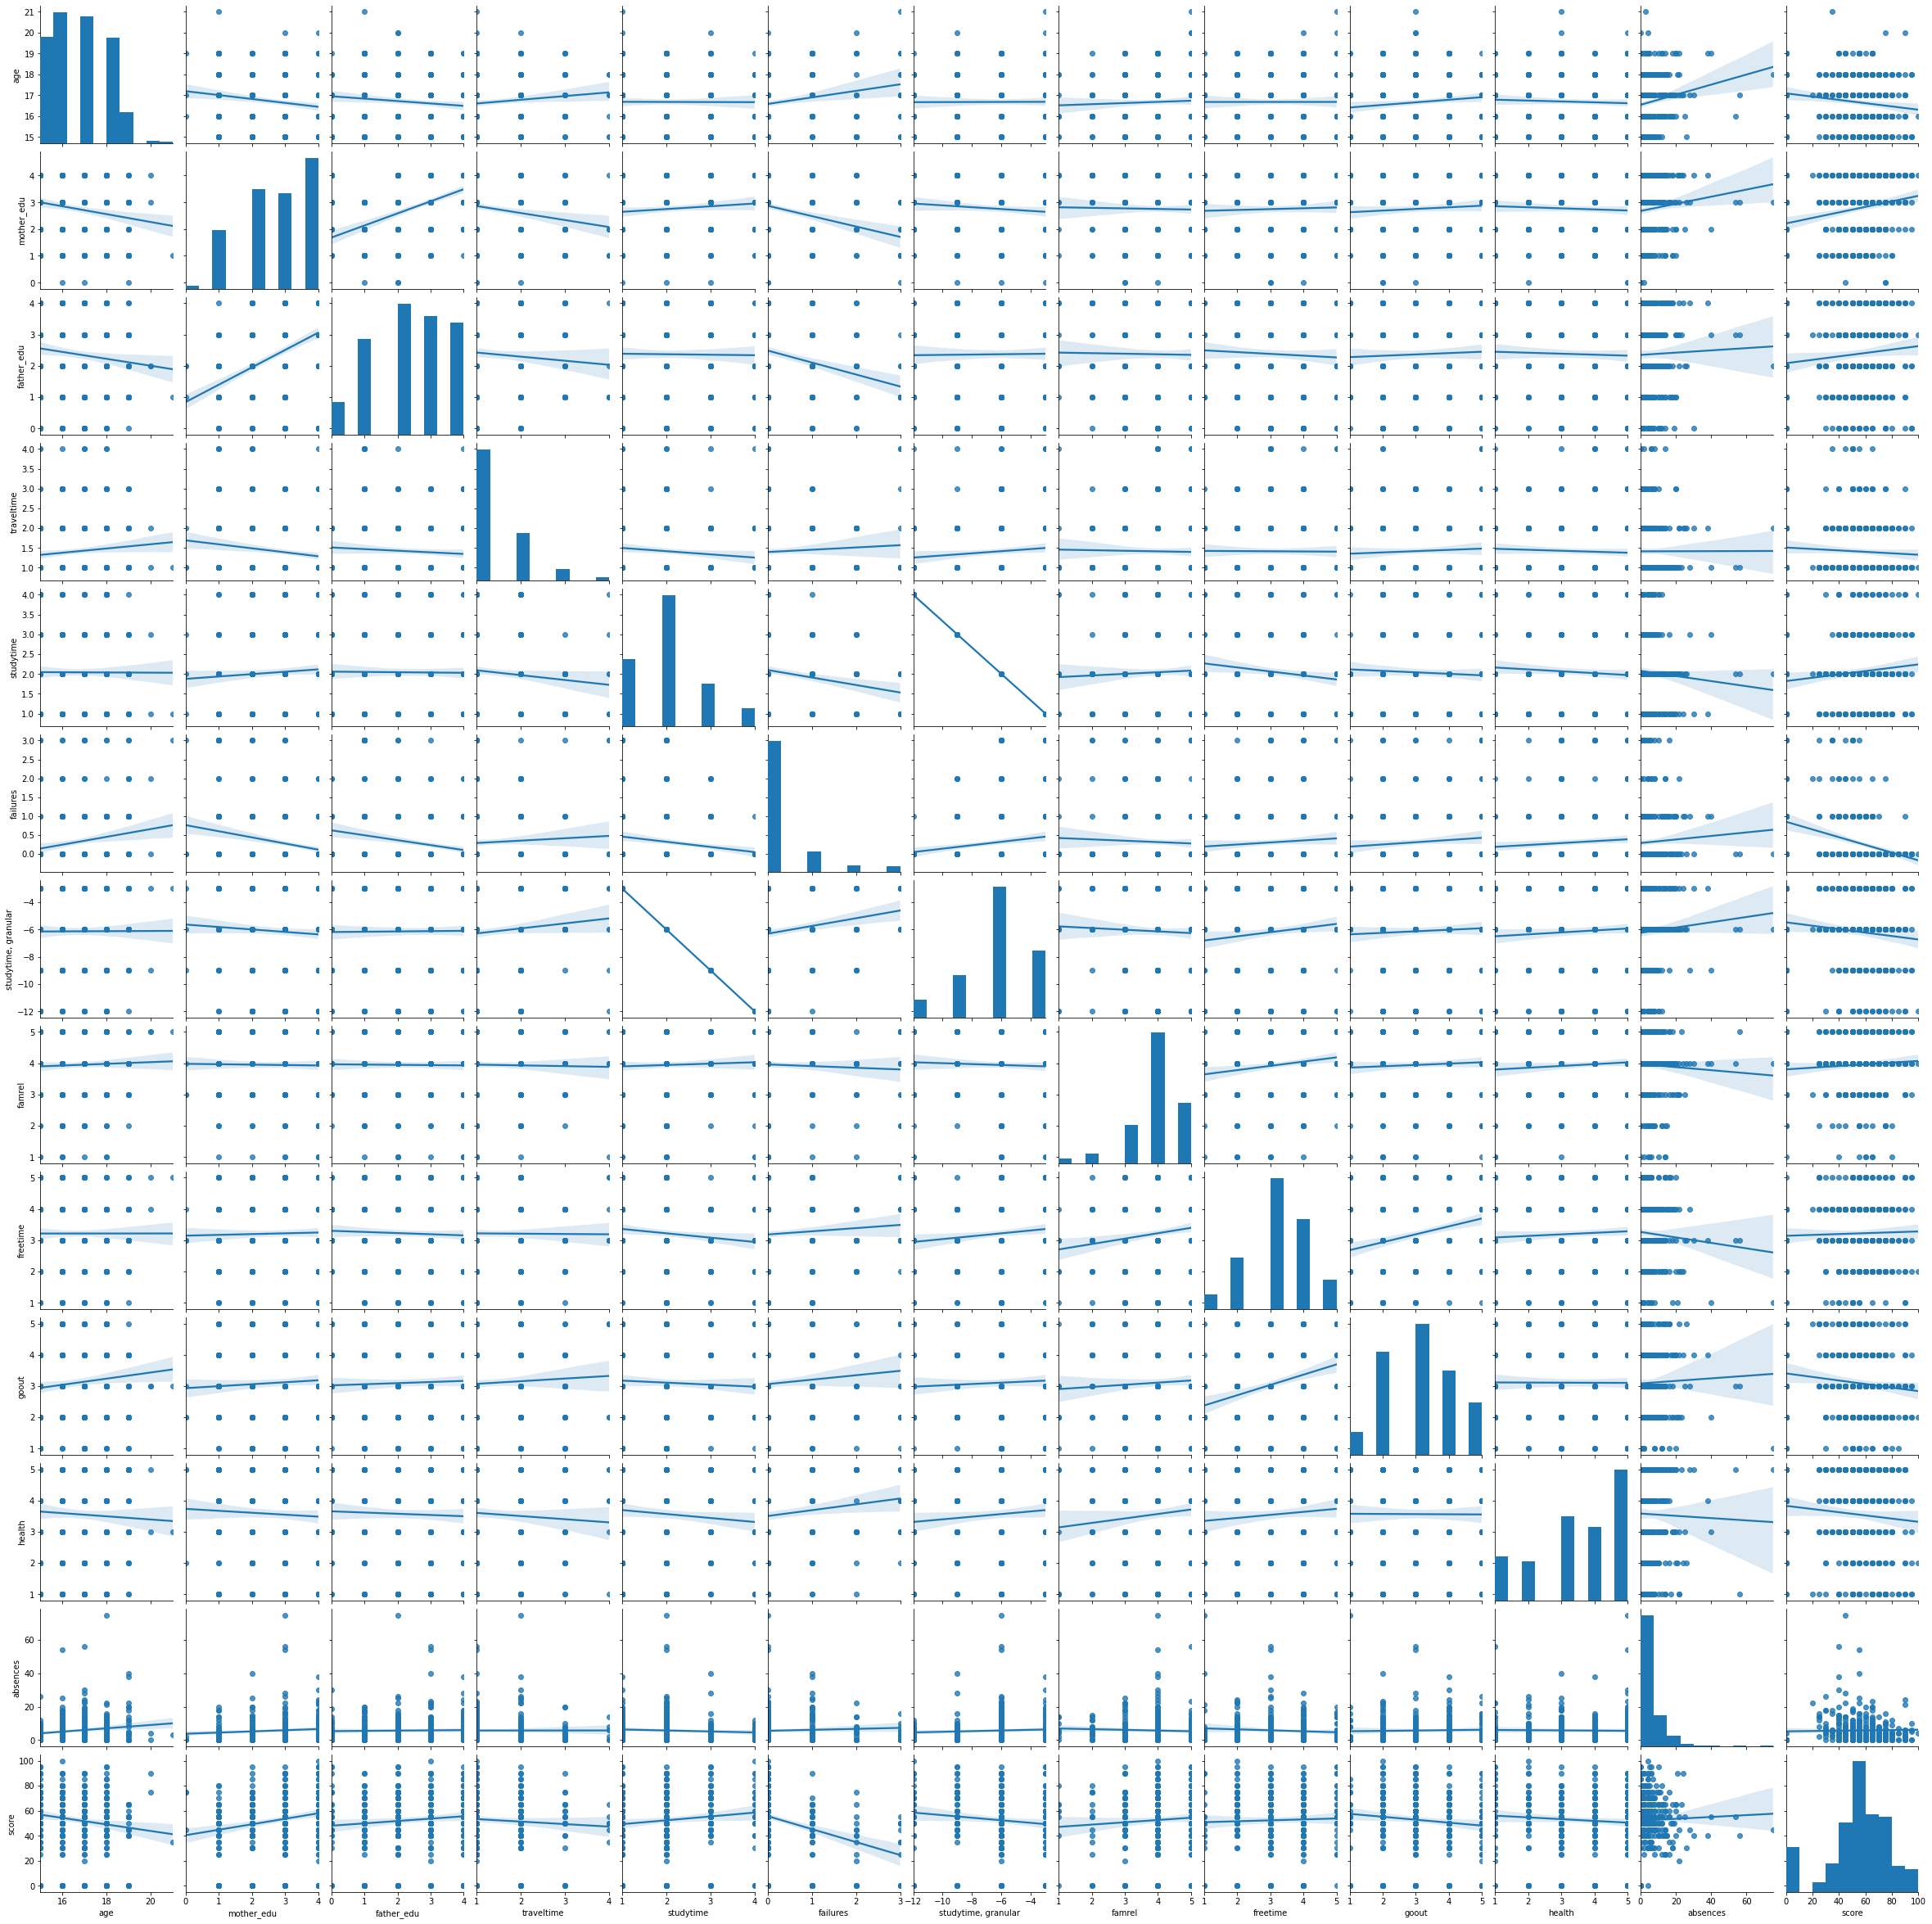

In [68]:
sns.pairplot(stud_math, kind='reg')

Видим, что признаки studytime и studytime, granular коррелируются практически 100%. Проверим формулой (на всякий случай)

In [69]:
stud_math.corr()

,age,mother_edu,father_edu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
age,1.000000,-0.165951,-0.112885,0.097794,-0.003698,0.180085,0.003698,0.038733,0.000441,0.110304,-0.046016,0.155587,-0.143114
mother_edu,-0.165951,1.000000,0.500271,-0.162291,0.078795,-0.250961,-0.078795,-0.016687,0.028049,0.061874,-0.049910,0.096620,0.212441
father_edu,-0.112885,0.500271,1.000000,-0.073172,-0.010834,-0.223774,0.010834,-0.012739,-0.045553,0.039208,-0.035037,0.023698,0.101629
traveltime,0.097794,-0.162291,-0.073172,1.000000,-0.099441,0.060131,0.099441,-0.018778,-0.006819,0.052192,-0.050304,0.001376,-0.060428
studytime,-0.003698,0.078795,-0.010834,-0.099441,1.000000,-0.160826,-1.000000,0.042278,-0.118393,-0.049296,-0.077563,-0.061492,0.113760
failures,0.180085,-0.250961,-0.223774,0.060131,-0.160826,1.000000,0.160826,-0.043882,0.074220,0.091203,0.097059,0.052510,-0.325742
"studytime, granular",0.003698,-0.078795,0.010834,0.099441,-1.000000,0.160826,1.000000,-0.042278,0.118393,0.049296,0.077563,0.061492,-0.113760
famrel,0.038733,-0.016687,-0.012739,-0.018778,0.042278,-0.043882,-0.042278,1.000000,0.153394,0.054150,0.090624,-0.044886,0.070381
freetime,0.000441,0.028049,-0.045553,-0.006819,-0.118393,0.074220,0.118393,0.153394,1.000000,0.288920,0.069055,-0.071344,0.032255
goout,0.110304,0.061874,0.039208,0.052192,-0.049296,0.091203,0.049296,0.054150,0.288920,1.000000,-0.004339,0.029413,-0.115537


Формула показывает полную корреляцию этих двух признаков, так что признак studytime, granular можно смело "убирать"

In [70]:
stud_math.drop(['studytime, granular'], axis='columns', inplace=True)

Проверим насколько удачно прошло удаление

In [71]:
print(list(stud_math))

['school', 'sex', 'age', 'address', 'famsize', 'pstatus', 'mother_edu', 'father_edu', 'mother_job', 'father_job', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health', 'absences', 'score']


Пройдемся по колонкам с номинативными значениями: 'school', 'sex', 'address', 'famsize', 'pstatus', 'mother_job', 'father_job', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'

Рассмотрим признак 'school' на наличие пропущенных значений

In [73]:
stud_math.school.isna().sum()

0

Пропущенных значений нет. Перейдем к признаку 'sex'. Посмотрим есть ли пропущенные значения и много ли их

In [74]:
stud_math.sex.unique()

array(['F', 'M'], dtype=object)

In [75]:
stud_math.sex.isna().sum()

0

Пустых значений нет. Я бы всетаки заменил (для удобства последующей работы и интерпретации) M на male и F на female

In [76]:
stud_math.sex = stud_math.sex.apply(
    lambda x: 'male' if x == 'M' else 'female' if x == 'F' else x)
stud_math.sex.value_counts()

female    206
male      183
Name: sex, dtype: int64

Посмотрим на колонку 'address'. Есть ли пустые значения и много ли их

In [77]:
stud_math.address.unique()

array(['U', nan, 'R'], dtype=object)

In [78]:
stud_math.address.isna().sum()

16

Для удобства последующей работы заменим значения в колонке U на urban и R на region

In [79]:
stud_math.address = stud_math.address.apply(
    lambda x: 'urban' if x == 'U' else 'region' if x == 'R' else x)
display(stud_math.address.unique())

array(['urban', nan, 'region'], dtype=object)

Пропущенных значений довольно много, чтобы просто удалить эти строки и никак предположить кто из отвечавших живет в городе, а кто за его пределами, мы не можем. Поэтому просто заменяю NaN на ответ 'no_answer'

In [80]:
stud_math.address.fillna('no_answer', inplace=True)
stud_math.address.unique()

array(['urban', 'no_answer', 'region'], dtype=object)

Очередь колонки famsize. Посмотрим какие есть уникальные значения, есть ли пропуски и много ли пустых значений.

In [81]:
stud_math.famsize.unique()

array([nan, 'GT3', 'LE3'], dtype=object)

In [82]:
stud_math.famsize.isna().sum()

27

Пустых значений очень много и нет никаких вариантов, кроме как заменить пустые значения на ответ 'no_answer'

In [83]:
stud_math.famsize.fillna('no_answer', inplace=True)
stud_math.famsize.unique()

array(['no_answer', 'GT3', 'LE3'], dtype=object)

Займемся колонкой 'pstatus'. Посмотрим какие есть уникальные значения, есть ли пропуски и сколько их

In [84]:
stud_math.pstatus.unique()

array(['A', nan, 'T'], dtype=object)

In [88]:
stud_math.pstatus.isna().sum()

43

Для удобства дальнейшей работы заменим A на apart и T на together

In [86]:
stud_math.pstatus = stud_math.pstatus.apply(
    lambda x: 'apart' if x == 'A' else 'together' if x == 'T' else x)
display(stud_math.pstatus.unique())

array(['apart', nan, 'together'], dtype=object)

Пропущенных значерий в признаке очень много. Но (!) у нас есть признак 'опекун', который некоторым образом связан с признаком "семейный статус", так как говорит нам о том есть ли ребенка мать или отец. Посмотрим какие значения "опекун" есть в строках с пропущенными значениями "Семейный статус"

In [89]:
stud_math[stud_math.pstatus.isna()].guardian

1      father
9      mother
11     father
15     mother
25     mother
28     mother
54     mother
63     mother
67     mother
81        NaN
96     mother
108    father
112    mother
131    mother
139    mother
147    mother
149    mother
153    mother
158    mother
174    mother
182    father
183    mother
186    mother
197    father
198    mother
210     other
227    father
234    mother
245    mother
252    mother
260    father
265    mother
266    mother
268    father
271    father
282    mother
298    father
307     other
313     other
333     other
342    mother
357    mother
364       NaN
Name: guardian, dtype: object

Видно, что в случае пропущенных значений статуса проживания семьи, статус опекуна все же есть и зачастую это один из родителей, так что уместно предположить, что можно заменить пропущенные значения значением apart (родители проживают по отдельности)

In [90]:
stud_math.pstatus.fillna('apart', inplace=True)

Рассмотрим колонку mother_job. Посмотрим какие есть уникальные значения и есть ли пропуски

In [91]:
stud_math.mother_job.unique()

array(['at_home', 'health', 'other', 'services', 'teacher', nan],
      dtype=object)

В данном случае nan легко можно заменить на столь же неинформативное other

In [92]:
stud_math.father_job.fillna('other', inplace=True)

Пройдемся по колонке reson. Посмотрим на то какие есть уникальные значения в этой колонке

In [93]:
stud_math.reason.unique()

array(['course', 'other', 'home', 'reputation', nan], dtype=object)

В данном случае nan тоже легко заменяются на other

In [95]:
stud_math.reason.fillna('other', inplace=True)

Посмотрим на колонку guardian. Какие в ней уникальные значения

In [96]:
stud_math.guardian.unique()

array(['mother', 'father', 'other', nan], dtype=object)

В данном случае скорее всего можно предположить, что nan можно заменить на other

In [98]:
stud_math.guardian.fillna('other', inplace=True)

Просмотрим колонку schoolsup. Какие есть уникальные значения, есть ли пропуски, сколько пропусков.

In [99]:
stud_math.schoolsup.unique()

array(['yes', 'no', nan], dtype=object)

In [100]:
stud_math.schoolsup.isna().sum()

9

Всего 9 значений. это 2% от общей базы. Таким количеством можно и пренебречь, то есть можно эти строки выкинуть.

In [101]:
stud_math.dropna(subset=['schoolsup'], inplace=True)

Посмотрим на признак famsup. Есть ли пропуски, сколько их, какие вообще есть уникальные значения.

In [102]:
stud_math.famsup.unique()

array(['no', 'yes', nan], dtype=object)

In [103]:
stud_math.famsup.isna().sum()

38

Cлишком много значений, чтобы их просто выбросить и нет никакой возможности предположить каким из имеющихся ответов заменить nan, так что заменим nan на "no_answer"

In [104]:
stud_math.famsup.fillna('no_answer', inplace=True)

Пройдемся по колонке paid

In [106]:
stud_math.paid.unique()

array(['no', nan, 'yes'], dtype=object)

In [107]:
stud_math.paid.isna().sum()

40

Значений тоже очень много. Поступим как в предыдущий раз - заменим nan на no_answer

In [108]:
stud_math.paid.fillna('no_answer', inplace=True)

Займемся колонкой 'activities'

In [109]:
stud_math.activities.unique()

array(['no', 'yes', nan], dtype=object)

In [110]:
stud_math.activities.isna().sum()

14

заменим Nan на 'no_answer'

In [111]:
stud_math.activities.fillna('no_answer', inplace=True)

Займемся колонкой 'nursery'

In [112]:
stud_math.nursery.unique()

array(['yes', 'no', nan], dtype=object)

In [113]:
stud_math.nursery.isna().sum()

16

Пустых значений тоже очень много. Поступим как в предыдущий раз - заменим nan на no_answer

In [115]:
stud_math.nursery.fillna('no_answer', inplace=True)

Займемся колонкой 'higher'

In [116]:
stud_math.higher.unique()

array(['yes', nan, 'no'], dtype=object)

In [117]:
stud_math.higher.isna().sum()

19

Пустых значений тоже очень много. Поступим как в предыдущий раз - заменим nan на no_answer

In [118]:
stud_math.higher.fillna('no_answer', inplace=True)

Очередь за колонкой 'internet'

In [119]:
stud_math.internet.unique()

array([nan, 'yes', 'no'], dtype=object)

In [120]:
stud_math.internet.isna().sum()

33

Значений тоже очень много. Поступим как в предыдущий раз - заменим nan на no_answer

In [121]:
stud_math.internet.fillna('no_answer', inplace=True)

А теперь колонка 'romantic'

In [122]:
stud_math.romantic.unique()

array(['no', nan, 'yes'], dtype=object)

In [123]:
stud_math.romantic.isna().sum()

29

Пустых значений тоже очень много. Поступим как в предыдущий раз - заменим nan на no_answer

In [125]:
stud_math.romantic.fillna('no_answer', inplace=True)

Все признаки почищены, пустых значений больше не осталось. Посмотрим на влияние номинативных переменных на оценку (score)

In [127]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.boxplot(x=column, y='score',
                data=stud_math)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

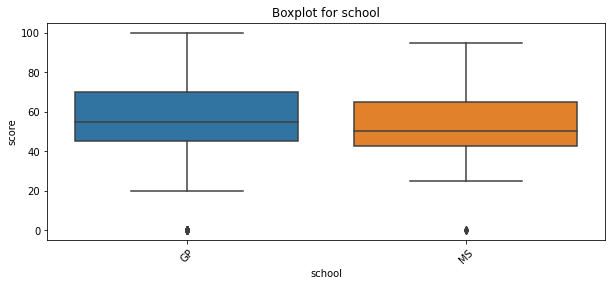

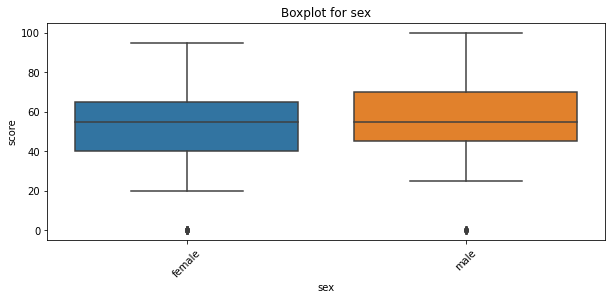

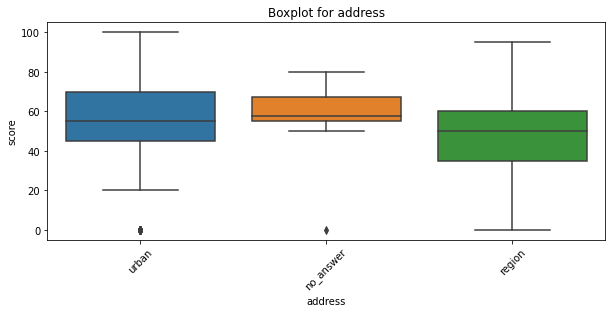

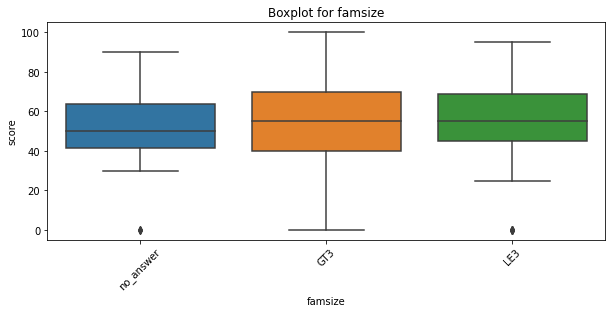

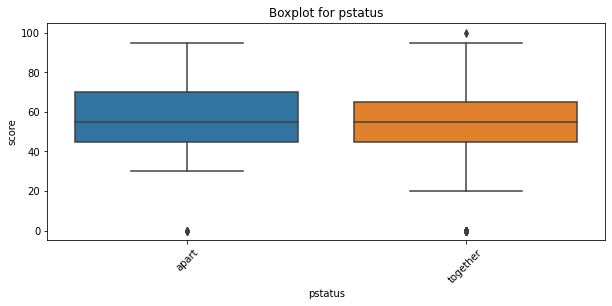

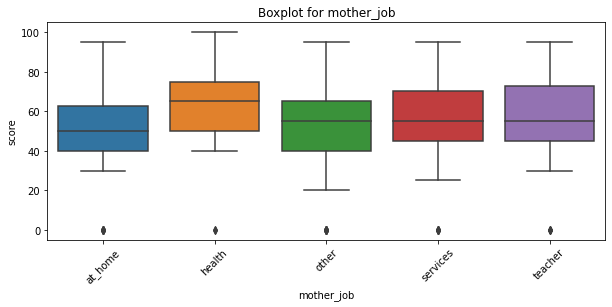

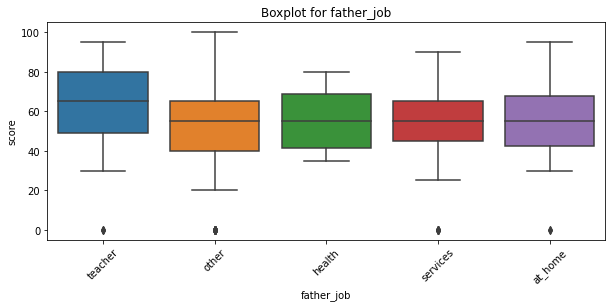

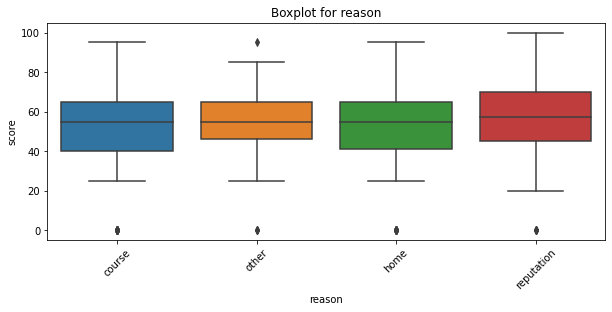

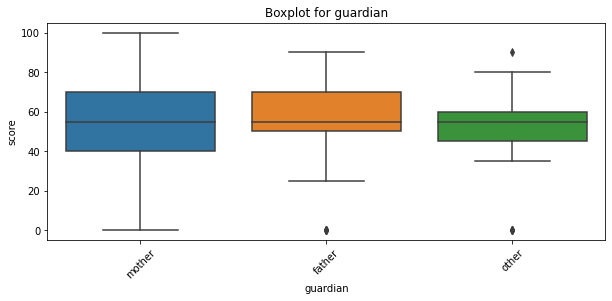

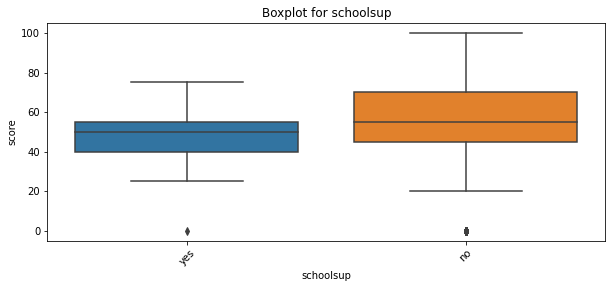

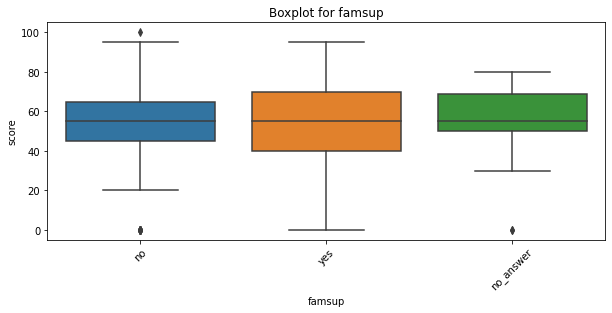

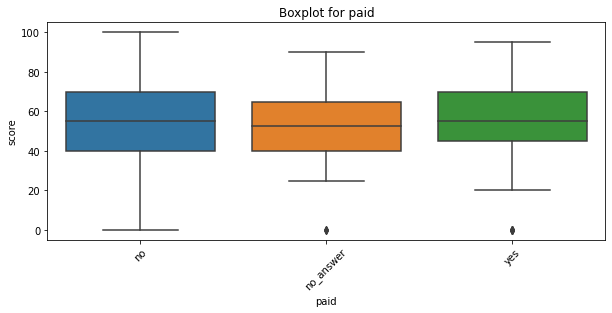

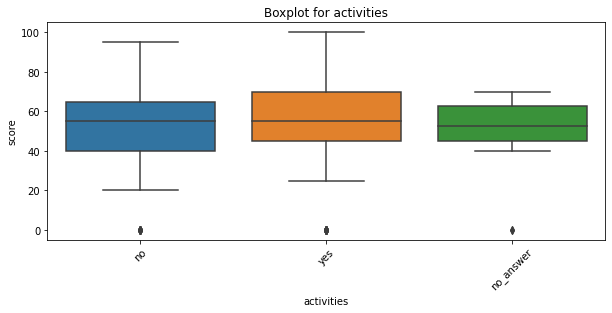

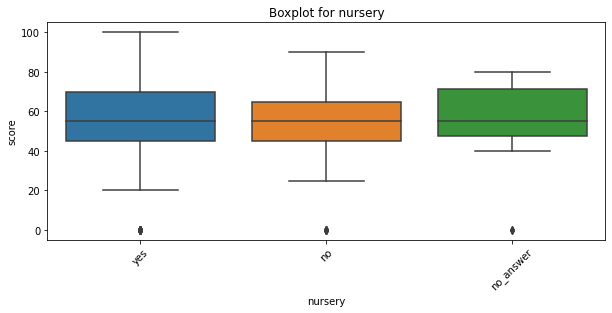

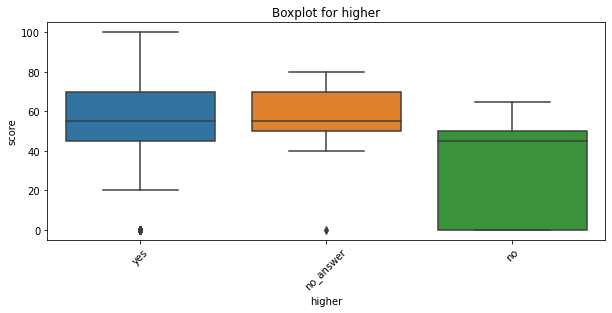

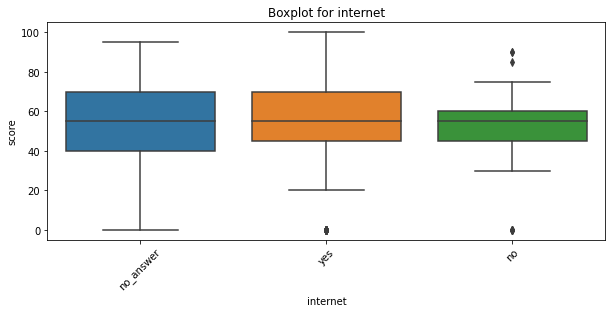

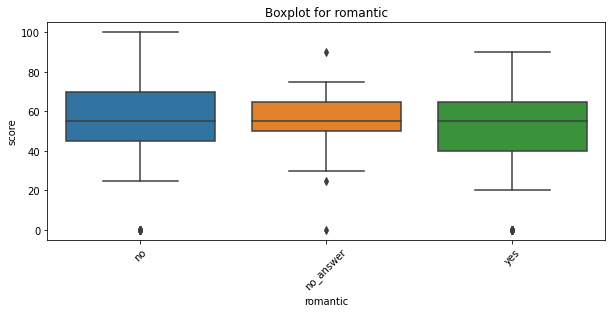

In [128]:
for col in ['school', 'sex', 'address', 'famsize', 'pstatus', 'mother_job', 'father_job',
            'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
            'higher', 'internet', 'romantic']:
    get_boxplot(col)

А теперь - тест Стьюдента. Он должен показать влияние каких признаков на score статистически значимо

In [129]:
def get_stat_dif(column):
    cols = stud_math.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], 'score'],
                     stud_math.loc[stud_math.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [130]:
for col in ['school', 'sex', 'age', 'address', 'famsize', 'pstatus', 'mother_edu', 'father_edu',
            'mother_job', 'father_job', 'reason', 'guardian', 'traveltime', 'studytime',
            'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
            'romantic', 'famrel', 'freetime', 'goout', 'health', 'absences', 'score']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки mother_edu
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки goout
Найдены статистически значимые различия для колонки absences
Найдены статистически значимые различия для колонки score


   Хотя визуально (при анализе boxplot-ов) кажется, что признаки address, mother_job, father_job, schoolsup и higher должны влиять на итоговый признак, тест показывает, что нет. Это крайне странно, но так как у меня нет даже догдок о том как в итоге будет работать эта база - доверюсь тесту.
   Но прежде чем делать итоговую базу сделаю еще одно. В самом начале - при работе с score я оставил строки с нулевыми значениями. Они, на самом деле, довольно странные, так означают, что ученик или просто не явился на тест или сумел ответить неверно на все вопросы. Посмотрим что будет, если эти строки удалить. 
   Сделаю копию исходного датасета и в нем удалю нулевые значения.

In [148]:
stud_math_copy = stud_math[stud_math.score > 0]

In [133]:
stud_math_copy.info()  # проверил, что точно удалились около 10% сета

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344 entries, 0 to 393
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      344 non-null    object 
 1   sex         344 non-null    object 
 2   age         344 non-null    int64  
 3   address     344 non-null    object 
 4   famsize     344 non-null    object 
 5   pstatus     344 non-null    object 
 6   mother_edu  344 non-null    float64
 7   father_edu  344 non-null    float64
 8   mother_job  327 non-null    object 
 9   father_job  344 non-null    object 
 10  reason      344 non-null    object 
 11  guardian    344 non-null    object 
 12  traveltime  344 non-null    float64
 13  studytime   344 non-null    float64
 14  failures    344 non-null    float64
 15  schoolsup   344 non-null    object 
 16  famsup      344 non-null    object 
 17  paid        344 non-null    object 
 18  activities  344 non-null    object 
 19  nursery     344 non-null    o

In [149]:
def get_stat_dif_copy(column):
    cols = stud_math_copy.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud_math_copy.loc[stud_math_copy.loc[:, column] == comb[0], 'score'],
                     stud_math_copy.loc[stud_math_copy.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [150]:
for col in ['school', 'sex', 'age', 'address', 'famsize', 'pstatus', 'mother_edu', 'father_edu',
            'mother_job', 'father_job', 'reason', 'guardian', 'traveltime', 'studytime',
            'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
            'romantic', 'famrel', 'freetime', 'goout', 'health', 'absences', 'score']:
    get_stat_dif_copy(col)

Найдены статистически значимые различия для колонки age
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки mother_edu
Найдены статистически значимые различия для колонки father_edu
Найдены статистически значимые различия для колонки mother_job
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки goout
Найдены статистически значимые различия для колонки absences
Найдены статистически значимые различия для колонки score


А вот в этом случае влияние признаков более разумно. Видим, что на оценку влияют и возраст и место проживание, образование отца и матери, работа матери, потраченное на учебу время, количество внеучебных неудач (что же это?), количество пропущенных занятий, проведенное с друзьями время и количество дополнительных занятий в школе. Этот вариант кажется мне более разумным, так что в качестве итоговой базы я бы использовал именно эту базу, с оставленными "значительными" признаками.

In [165]:
stud_math_final = stud_math_copy.loc[:, ['age', 'address', 'mother_edu', 'father_edu', 'mother_job',
                                         'studytime', 'failures', 'schoolsup', 'goout', 'absences', 'score']]
stud_math_final.head()

,age,address,mother_edu,father_edu,mother_job,studytime,failures,schoolsup,goout,absences,score
0,18,urban,4.0,4.0,at_home,2.0,0.0,yes,4.0,6.0,30.0
1,17,urban,1.0,1.0,at_home,2.0,0.0,no,3.0,4.0,30.0
2,15,urban,1.0,1.0,at_home,2.0,3.0,yes,2.0,10.0,50.0
3,15,urban,4.0,2.0,health,3.0,0.0,no,2.0,2.0,75.0
4,16,urban,3.0,3.0,other,2.0,0.0,no,2.0,4.0,50.0


# Выводы:
В результате анализа влияния различных признаков на оценку ученика по математике можно сделать следующие выводы:

1. Данные не достаточно чистые. Пустые значения встречаются в большом количестве во многих колонках. Кроме того основной признак score не чист, есть большое количество пропущенных значений и значений 0.0 (что трудно интерпретировать)
2. Выбросов в данных немного (если не принимать в рассчет странные нулевые значения score)
3. Найдена полная корреляция значений studytime и studytime, granular, что ничего не говорит (так как мы не значем что за параметр studytime, granular), но позволяет нам выбросить одну из этих колонок
4. Самые важные параметры, которые предлагается использовать для построения модели (знать бы еще что это, как это работает и т.п.): 'age', 'address', 'mother_edu', 'father_edu', 'mother_job', 'studytime', 'failures', 'schoolsup', 'goout', 'absences', 'score'. 